# Propensity Score Matching

This notebook illustrates how to do propensity score matching in Python.
Original dataset available at: http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets (search for rhs, download csv file for data, html file for file description)
Fro a presentation and key results on the topic, see: http://www.mc.vanderbilt.edu/crc/workshop_files/2008-04-11.pdf

## Import key packages

In [170]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


In [171]:
# allow graphs
%matplotlib inline

## Import data to a dataframe (called df)

In [172]:
#df = pd.read_csv(r'rhc.csv')
df = pd.read_csv(r'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.csv')

## Have a look at the data

In [173]:
df.head(5)

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


## Clean the Data

In [174]:
df=df.replace(to_replace = 'Yes', value = 1)
df=df.replace(to_replace = 'No', value = 0)

In [175]:
df.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,1,11142,11151.0,NaN,11382,0,0,...,0,0,0,0,0,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,0,11799,11844.0,11844.0,11844,1,1,...,0,0,1,0,0,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,1,12083,12143.0,NaN,12400,0,0,...,0,0,0,0,0,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,0,11146,11183.0,11183.0,11182,1,0,...,0,0,0,0,0,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,0,12035,12037.0,12037.0,12036,1,0,...,0,0,0,0,0,NaN,64.0,white,Under $11k,11


In [178]:
# how many received treatment? 
df.swang1.value_counts(normalize=True)

No RHC    0.61918
RHC       0.38082
Name: swang1, dtype: float64

In [153]:
# how many died in the treatment group (percent)
df['treated'] = 0
df['treated'] = df['treated'].where(df.swang1=='No RHC',1)



In [179]:
df['treated'] = np.where(df.swang1 == 'RHC', 1, 0)

In [180]:
df.groupby('treated')['death'].mean()

treated
0    0.629682
1    0.680403
Name: death, dtype: float64

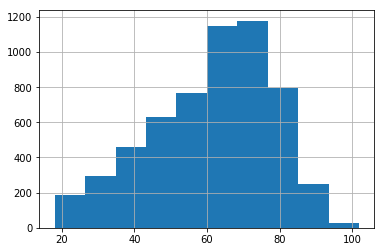

In [181]:
# age distribution
df.age.hist();

## Logit regression (to compare the results with Propensity matching method)

In [186]:
model = 'death ~ age + sex + edu + treated'
reg_results = smf.logit(formula=model, data=df).fit()
reg_results.summary()

Optimization terminated successfully.
         Current function value: 0.622953
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  death   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5730
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Nov 2018   Pseudo R-squ.:                 0.03875
Time:                        13:33:46   Log-Likelihood:                -3572.6
converged:                       True   LL-Null:                       -3716.7
                                        LLR p-value:                 4.112e-61
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2474      0.168     -7.406      0.000      -1.577      -0.917
sex[T.Male]     0.1074      0.057      1.878      0.060      -0.005       0.219
age             0.0277      0.002     15.970      0.000       0.024       0.031
edu             0.0030      0.009      0.327      0.743      -0.015       0.021
treated         0.2526      0.059      4.278      0.000       0.137       0.368
===============================================================================
"""

In [188]:
np.exp(reg_results.params)

Intercept      0.287255
sex[T.Male]    1.113332
age            1.028086
edu            1.003032
treated        1.287403
dtype: float64

In [61]:
df.edu.describe()

count    5735.000000
mean       11.678461
std         3.145831
min         0.000000
25%        10.000000
50%        12.000000
75%        13.000000
max        30.000000
Name: edu, dtype: float64

## Estimate propensity score

In [191]:
df.sex = df.sex.replace('Male', 0)
df.sex = df.sex.replace('Female', 1)



In [194]:
df['male'] = np.where(df.sex == 0, 1, 0)

In [196]:
model = 'treated ~ age + male +edu'
propensity = smf.logit(formula=model, data = df).fit()
propensity.summary()

Optimization terminated successfully.
         Current function value: 0.662209
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5731
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Nov 2018   Pseudo R-squ.:                0.003394
Time:                        14:27:16   Log-Likelihood:                -3797.8
converged:                       True   LL-Null:                       -3810.7
                                        LLR p-value:                 1.017e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7441      0.160     -4.645      0.000      -1.058      -0.430
age           -0.0027      0.002     -1.648      0.099      -0.006       0.001
male           0.1858      0.055      3.374      0.001       0.078       0.294
edu            0.0273      0.009      3.111      0.002       0.010       0.045
==============================================================================
"""

## Check overlap

In [198]:
df.groupby('treated').size()
df.groupby('treated').male.mean()

treated
0    0.539003
1    0.585165
Name: male, dtype: float64

treated
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

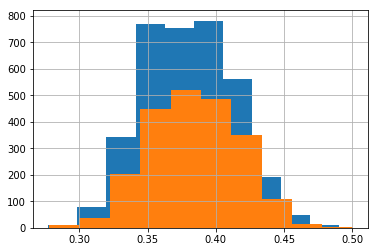

In [201]:
df['propensity'] = propensity.predict()
df.groupby('treated')['propensity'].hist()


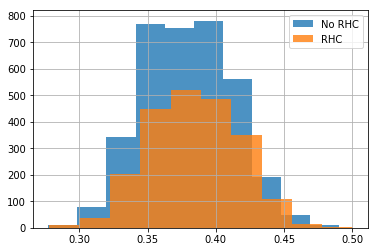

In [204]:
import matplotlib.pyplot as plt
df.groupby('treated')['propensity'].hist(alpha=0.8)
plt.legend(['No RHC','RHC'])

In [205]:
df.groupby('treated')['propensity'].mean()

treated
0    0.379108
1    0.383603
Name: propensity, dtype: float64

In [207]:
# Are the treated different in terms of age, sex and edu?
df.groupby('treated')['age', 'male', 'edu'].mean()

,age,male,edu
treated,,,
0,61.760926,0.539003,11.569005
1,60.749836,0.585165,11.856428


## Do matching (ten groups)

In [208]:
df.propensity.head()

0    0.396208
1    0.347837
2    0.381078
3    0.331200
4    0.384368
Name: propensity, dtype: float64

In [215]:
df[['propensity','group']].head(11)

,propensity,group
0,0.396208,3
1,0.347837,3
2,0.381078,3
3,0.331200,3
4,0.384368,3
5,0.318814,3
6,0.419408,4
7,0.413605,4
8,0.391037,3
9,0.360308,3


In [209]:
# Everybody between 0 and 0.09999999 will end up in group 0, 0.1 to 0.1999999999 in group 1

df['group'] = (df.propensity*10).astype(int)

In [210]:
# percentages who die in the different groups
df.groupby('group')['death'].mean()

group
2    0.695652
3    0.670981
4    0.595983
5    1.000000
Name: death, dtype: float64

In [37]:
# distinguish between treated and untreated in the different groups and see how many who die

df.groupby(['group', 'treated'])['death'].mean()

group  treated
2      0          0.538462
       1          0.900000
3      0          0.649882
       1          0.707317
4      0          0.579317
       1          0.619799
5      1          1.000000
Name: death, dtype: float64

In [39]:
# same thing, but easier to see if we stack it
df.groupby(['group', 'treated'])['death'].mean().unstack('treated')

treated,0,1
group,,
2,0.538462,0.900000
3,0.649882,0.707317
4,0.579317,0.619799
5,NaN,1.000000


## Calculate overall average effect of treatment (on the treated)

In [211]:
psTable=df.groupby(['group', 'treated'])['death'].mean().unstack('treated')
psTable

treated,0,1
group,,
2,0.538462,0.900000
3,0.649882,0.707317
4,0.579317,0.619799
5,NaN,1.000000


In [212]:
psTable.columns = ['untreated', 'treated']

In [213]:
psTable['difference'] = psTable.treated - psTable.untreated

In [214]:
psTable

,untreated,treated,difference
group,,,
2,0.538462,0.900000,0.361538
3,0.649882,0.707317,0.057435
4,0.579317,0.619799,0.040482
5,NaN,1.000000,NaN


In [45]:
# end result, average effect of treatment on mortality

psTable.difference.mean()

0.1531518073699852

In [46]:
psTable.mean()

untreated     0.589220
treated       0.806779
difference    0.153152
dtype: float64

In [59]:
# how many individuals are in the different groups?
df.groupby(['group', 'treated']).size().unstack('treated')

treated,0,1
group,,
2,13.0,10.0
3,2542.0,1476.0
4,996.0,697.0
5,NaN,1.0


In [60]:
# what is the balance (age, edu etc in the different groups)

df.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated')

age                  sex                  edu           
treated          0          1         0         1          0          1
group                                                                  
2        79.668124  70.251468  1.000000  1.000000   2.846154   1.700000
3        66.084293  64.332149  0.619591  0.590786  10.725295  10.819763
4        50.493061  53.020573  0.049197  0.034433  13.836182  14.175709
5              NaN  65.535950       NaN  0.000000        NaN  27.000000

In [61]:
# overall group average

df.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated').mean()

     treated
age  0          65.415159
     1          63.285035
sex  0           0.556263
     1           0.406305
edu  0           9.135877
     1          13.423868
dtype: float64

In [96]:
grp_name =['0-29','30-59','60-']
bins = [-1,29,59,222]
df['agegrp'] = pd.cut(df.age, bins = bins,labels = grp_name)

In [134]:
#!pip install lifelines


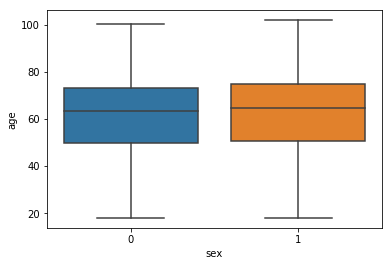

In [145]:
(df.age/10).astype(int)
sns.boxplot(x = df.sex,y=df.age)
#hue=df.treated,whis=1)